In [4]:
import tensorflow as tf
import tensorflow.keras as keras

import pathlib
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import random
import numpy as np
import os
from glob import glob
from tqdm import tqdm
import requests
import cv2
from PIL import Image


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


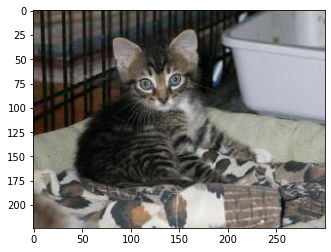

In [7]:
from matplotlib import pyplot as plt
im = plt.imread("/content/drive/MyDrive/Colab Notebooks/Asirra_ cat vs dogs/cat.12.jpg")
plt.imshow(im)
plt.show()

In [8]:
def extract_ground_truth(path):
    """Extracts ground truths like boxes, labels and ids from xml files."""
    
    boxes = []
    labels = []
    ids = []
    
    tree = ET.parse(path)
    id_i = path.split("/")[-1].split(".")[1]
    objects = tree.getroot().findall("object")

    for object_i in objects:
        object_name = object_i.find("name").text
        if object_name=="cat":
            instances = object_i.findall("bndbox")
            for instance in instances:
                xmin = int(float(instance.find("xmin").text))
                xmax = int(float(instance.find("xmax").text))
                ymin = int(float(instance.find("ymin").text))
                ymax = int(float(instance.find("ymax").text))
                box = np.array([xmin, xmax, ymin, ymax])
                boxes.append(box)
                labels.append(object_name)
                ids.append(id_i)    
        return np.array(boxes), np.array(labels), np.array(ids)

In [9]:
def region_proposals(image):
    """Generates region proposals using Selective Search"""
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    
    prediction_rects = _restructure_rectangles_xx(rects)
    return prediction_rects

def _restructure_rectangles_xx(old_rects):
    """Converts rectangles from (x, y, w, h) to (x1, x2, y1, y2)""" 
    x1 = old_rects[:,0]
    x2 = old_rects[:,2]+old_rects[:,0]
    y1 = old_rects[:,1]
    y2 = old_rects[:,1]+old_rects[:,3]

    rects_new = old_rects.copy()
    rects_new[:,0] = x1
    rects_new[:,1] = x2
    rects_new[:,2] = y1
    rects_new[:,3] = y2
    return rects_new

In [10]:
def images_to_file(image, boxes, labels, predicted_rectangles, image_id, path="."):
    """Crops boxes and writes images to files."""
    
    if not os.path.exists(f"{path}/{labels[0]}"):
        os.makedirs(f"{path}/{labels[0]}")
    if not os.path.exists(f"{path}/no_category"):
        os.makedirs(f"{path}/no_category")        
    
    # Iterate through boxes
    for box, label, i_id in zip(boxes, labels, image_id):
        i_pos = i_neg = 0
        for rect in predicted_rectangles:  
            iou = _get_iou(box,rect)
            if iou > 0.5:
                i_pos +=1
                file_name = f"{path}/{label}/{i_id}_{i_pos}.jpg"
                cropped_image = image[rect[2]:rect[3], rect[0]:rect[1]]
                img = Image.fromarray(cropped_image, 'RGB')
                img2 = img.resize((227,227), Image.ANTIALIAS)
                img2.save(file_name)
            elif iou < 0.1 and i_neg < 50:
                if (rect[3]-rect[2])>20 and (rect[1]-rect[0])>20: 
                    i_neg += 1
                    file_name = f"{path}/no_category/{label}_{i_id}_{i_neg}.jpg"
                    cropped_image = image[rect[2]:rect[3], rect[0]:rect[1]]
                    img = Image.fromarray(cropped_image, 'RGB')
                    img2 = img.resize((227,227), Image.ANTIALIAS)
                    img2.save(file_name)

# Inspired by https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation
def _get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : array
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : array
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1[0] < bb1[1]
    assert bb1[2] < bb1[3]
    assert bb2[0] < bb2[1]
    assert bb2[2] < bb2[3]

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[2], bb2[2])
    x_right = min(bb1[1], bb2[1])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[1] - bb1[0]) * (bb1[3] - bb1[2])
    bb2_area = (bb2[1] - bb2[0]) * (bb2[3] - bb2[2])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [11]:
from glob import glob
metadata_paths = sorted(glob("/content/drive/MyDrive/Colab Notebooks/Asirra_ cat vs dogs/cat*.xml"))
images_paths = sorted(glob("/content/drive/MyDrive/Colab Notebooks/Asirra_ cat vs dogs/cat*.jpg"))

In [12]:
!pip3 install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
import numpy as np
import xml.etree.ElementTree as ET
import os
import cv2
from tqdm import tqdm
for metadata_path, image_path in tqdm(zip(metadata_paths, images_paths)):
    if os.stat(image_path).st_size < 100000:
      image = cv2.imread(image_path)
      truth_recangles, truth_label, image_id = extract_ground_truth(metadata_path)
      if truth_label:
            predicted_rectangles = region_proposals(image)
            images_to_file(image, truth_recangles, truth_label, predicted_rectangles, image_id, "./training")

136it [04:12,  1.13s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  # Remove the CWD from sys.path while we load stuff.
550it [15:05,  1.65s/it]


In [14]:
data_train = keras.utils.image_dataset_from_directory("./training", image_size=(227,227))

Found 42057 files belonging to 2 classes.


In [15]:
data_train.class_names

['cat', 'no_category']

In [16]:
class_weight = {0: 5, 1: 1}

input_l = keras.layers.Input(shape=(227, 227, 3))
input_layer = keras.layers.Rescaling(1./255)(input_l)
input_layer = keras.layers.ZeroPadding2D((16,16))(input_layer)
input_layer = keras.layers.RandomCrop(227,227)(input_layer)
input_layer = keras.layers.RandomFlip("horizontal")(input_layer)

headModel = keras.applications.MobileNetV2(weights="imagenet", include_top=False,input_tensor=input_layer)

for layer in headModel.layers:
    layer.trainable = False
    
headModel = headModel.output

baseModel = keras.layers.AveragePooling2D(pool_size=(7, 7))(headModel)
baseModel = keras.layers.Flatten(name="flatten")(baseModel)
baseModel = keras.layers.Dense(128, activation="relu")(baseModel)
baseModel = keras.layers.Dropout(0.3)(baseModel)
output = keras.layers.Dense(2, activation="softmax")(baseModel)


model = keras.models.Model(inputs=input_l, outputs=output)

9420800/9406464 [==============================] - 0s 0us/step


In [17]:
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

history = model.fit(data_train, epochs=10, batch_size=64, class_weight=class_weight)

Epoch 1/10
1315/1315 [==============================] - 88s 56ms/step - loss: 0.1047 - accuracy: 0.9790
Epoch 2/10
1315/1315 [==============================] - 76s 57ms/step - loss: 0.0696 - accuracy: 0.9850
Epoch 3/10
1315/1315 [==============================] - 73s 55ms/step - loss: 0.0542 - accuracy: 0.9885
Epoch 4/10
1315/1315 [==============================] - 73s 55ms/step - loss: 0.0515 - accuracy: 0.9891
Epoch 5/10
1315/1315 [==============================] - 76s 57ms/step - loss: 0.0449 - accuracy: 0.9896
Epoch 6/10
1315/1315 [==============================] - 76s 57ms/step - loss: 0.0405 - accuracy: 0.9914
Epoch 7/10
1315/1315 [==============================] - 73s 55ms/step - loss: 0.0368 - accuracy: 0.9921
Epoch 8/10
1315/1315 [==============================] - 75s 57ms/step - loss: 0.0361 - accuracy: 0.9919
Epoch 9/10
1315/1315 [==============================] - 74s 56ms/step - loss: 0.0311 - accuracy: 0.9928
Epoch 10/10
1315/1315 [==============================] - 74s 56m

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 227, 227, 3)  0           ['input_1[0][0]']                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 259, 259, 3)  0          ['rescaling[0][0]']              
                                                                                                  
 random_crop (RandomCrop)       (None, 227, 227, 3)  0           ['zero_padding2d[0][0]']     

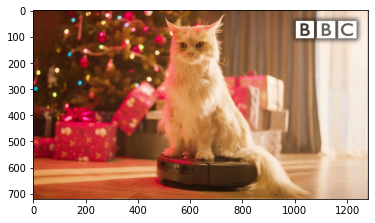

In [19]:
prediction_sample = "https://i.ytimg.com/vi/K1Xkt1E7PJY/maxresdefault.jpg"

response = requests.get(prediction_sample)

with open("./prediction.jpg", 'wb') as f:
    f.write(response.content)

prediction = plt.imread("./prediction.jpg")

plt.imshow(prediction)
plt.show()

In [20]:
def images_to_file_prediction(image, predicted_rectangles, path="."):
    """Crops boxes and writes images to files."""

    if not os.path.exists(f"{path}/"):
        os.makedirs(f"{path}/")
 
    i_id = 0
    
    for predicted_rectangle in predicted_rectangles:
        file_name = f"{path}/{i_id}.jpg"
        cropped_image = image[predicted_rectangle[2]:predicted_rectangle[3], predicted_rectangle[0]:predicted_rectangle[1]]
        img = Image.fromarray(cropped_image, 'RGB')
        img2 = img.resize((227,227), Image.ANTIALIAS)
        img2.save(file_name)
        i_id +=1

In [21]:
predicton_rectangles = region_proposals(prediction)
images_to_file_prediction(prediction, predicton_rectangles, path="./prediction/pred")

In [22]:
# When doing prediction ALWAYS set the shuffle parameter to False. Otherwise you can't trace the order of files correctly.
prediction_data = keras.utils.image_dataset_from_directory("./prediction", image_size=(227,227), shuffle=False)

# Model prediction
prediction_output = model.predict(prediction_data, batch_size=1)

Found 3655 files belonging to 1 classes.


In [23]:
def _restructure_rectangles_xy(old_rects):
    """Converts rectangles from (x, y, w, h) to (x1, y1, x2, y2)""" 
    x1 = old_rects[:,0]
    x2 = old_rects[:,1]
    y1 = old_rects[:,2]
    y2 = old_rects[:,3]

    rects_new = old_rects.copy()
    rects_new[:,1] = x1
    rects_new[:,0] = y1
    rects_new[:,3] = x2
    rects_new[:,2] = y2
    return rects_new

new_pred_rects = _restructure_rectangles_xy(predicton_rectangles)

In [24]:
# Method that "prunes away boxes that have high intersection-over-union (IOU) overlap with previously selected boxes" (Tensorflow Docs)
predictions = tf.image.non_max_suppression(new_pred_rects, prediction_output[:,0], max_output_size=3, iou_threshold=0.5)

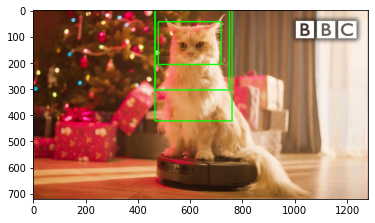

In [25]:
image = plt.imread("./prediction.jpg")

for ind_rect in predictions.numpy():
    img_index = int(prediction_data.file_paths[ind_rect].split("/")[-1].split(".")[0])
    rectangle_coordinates = predicton_rectangles[img_index].astype(int)
    rectangled_image = cv2.rectangle(image, (rectangle_coordinates[0], rectangle_coordinates[2]), (rectangle_coordinates[1], rectangle_coordinates[3]), (0, 255, 0), 3)
    plt.imshow(rectangled_image)

plt.show()